<a href="https://colab.research.google.com/github/Omega-84/ML-Capstone-Project-Regression-TedTalksViewPrediction/blob/individual/Ted_talks_Eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import io
import os
import re,unicodedata
import shutil
import string
import tensorflow as tf
import inflect
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Capstone 3 Regression/data_ted_talks.csv")

In [ ]:
df.head()

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...",272.0,977,"['alternative energy', 'cars', 'climate change...","{243: 'New thinking on the climate crisis', 54...",https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...


In [ ]:
df.shape

(4005, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

In [ ]:
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

comments          16.354557
occupations       13.033708
about_speakers    12.559301
all_speakers       0.099875
recorded_date      0.024969
transcript         0.000000
published_date     0.000000
title              0.000000
speaker_1          0.000000
views              0.000000
event              0.000000
description        0.000000
native_lang        0.000000
available_lang     0.000000
duration           0.000000
topics             0.000000
related_talks      0.000000
url                0.000000
talk_id            0.000000
dtype: float64

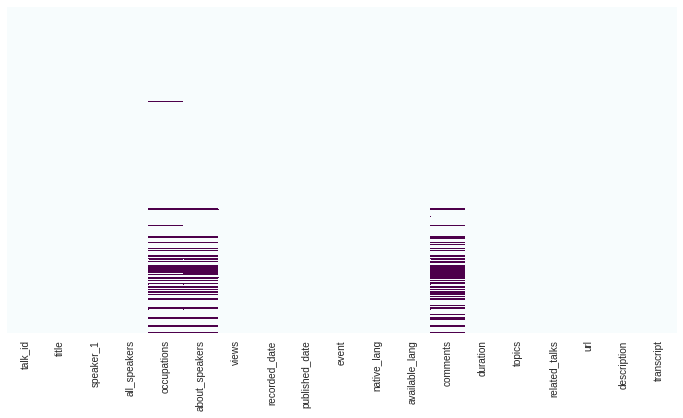

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='BuPu');

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
talk_id,4005.0,1.243254e+04,1.744758e+04,1.0,1252.0,2333.0,23777.0,62794.0
views,4005.0,2.148006e+06,3.451226e+06,0.0,882069.0,1375508.0,2133110.0,65051954.0
comments,3350.0,1.619970e+02,2.688389e+02,0.0,38.0,89.0,188.0,6449.0
duration,4005.0,7.240112e+02,3.617755e+02,60.0,393.0,738.0,974.0,3922.0


In [ ]:
df.duplicated().value_counts()

False    4005
dtype: int64

In [ ]:
df['talk_id'].nunique() == len(df)

True

## All unique entries

In [ ]:
df.drop(['talk_id','url'],axis=1,inplace=True)

In [ ]:
df['occupations'].fillna(str({0:'Other'}),axis=0,inplace=True)

In [ ]:
for i,r in enumerate(df.to_dict('records')):
  if pd.isnull(r['all_speakers']):
    dct = {0:r['speaker_1']}
    df['all_speakers'][i] = str(dct)

In [ ]:
cols_to_eval = ['all_speakers','occupations','available_lang','topics','related_talks']

In [ ]:
for i in cols_to_eval:
  df[i] = df.apply(lambda row: eval(row[i]), axis=1)

In [ ]:
df[df['recorded_date'].isnull()]

,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,description,transcript
3831,The unpaid work that GDP ignores -- and why it...,Marilyn Waring,{0: 'Marilyn Waring'},{0: ['economist']},{0: 'Marilyn Waring advocates for a public pol...,1276272,NaN,2020-01-23,TEDxChristchurch,en,"[en, es, fr, it, ko, pt, tr, vi, zh-cn, zh-tw]",20.0,1039,"[global development, development, social chang...",{46582: 'Why governments should prioritize wel...,"If you: do laundry, are (or have been) pregnan...",(In Maori: My mountain is Taupiri.) (Waikato i...


In [ ]:
def str_to_date(x):
  try:
    return datetime.strptime(x,"%Y-%m-%d")
  except TypeError:
    pass 

In [ ]:
df['published_date'] = df['published_date'].apply(str_to_date)

In [ ]:
df['recorded_date'] = df['recorded_date'].apply(str_to_date)

In [ ]:
df['date_diff'] = df['published_date'] - df['recorded_date']

In [ ]:
df['recorded_date'].fillna(df['published_date'] - df['date_diff'].median(),axis=0,inplace=True)

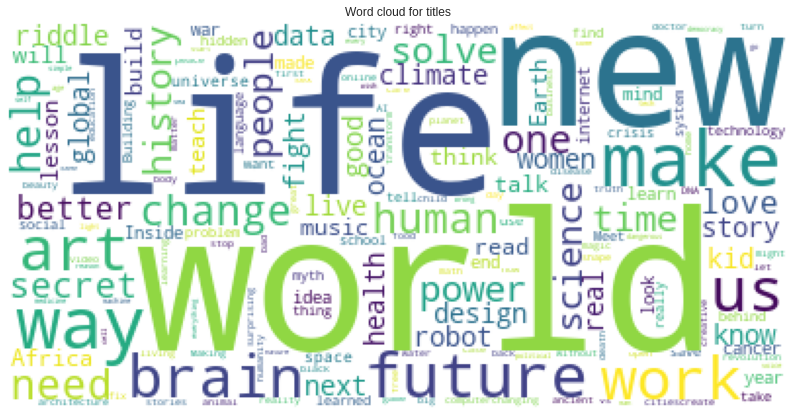

In [ ]:
plt.figure(figsize = (14,8))
wc = WordCloud(max_words = 500 ,background_color = 'white',collocations=False).generate(" ".join(df['title']))
plt.grid("off")
plt.axis("off")
plt.title("Word cloud for titles")
plt.imshow(wc);

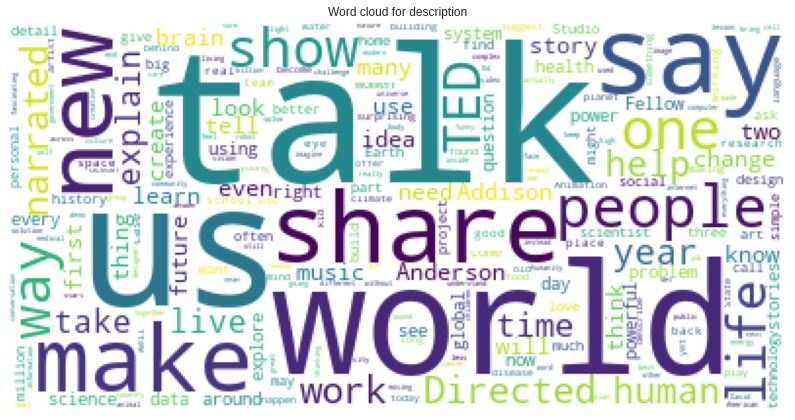

In [ ]:
plt.figure(figsize = (14,8))
wc = WordCloud(max_words = 500 ,background_color = 'white',collocations=False).generate(" ".join(df['description']))
plt.grid("off")
plt.axis("off")
plt.title("Word cloud for description")
plt.imshow(wc);

In [ ]:
df.nlargest(5, ['views'])[['title','speaker_1','views']]

,title,speaker_1,views
4,Do schools kill creativity?,Sir Ken Robinson,65051954
1296,Your body language may shape who you are,Amy Cuddy,57074270
2062,This is what happens when you reply to spam email,James Veitch,56932551
646,How great leaders inspire action,Simon Sinek,49730580
796,The power of vulnerability,Brené Brown,47544833


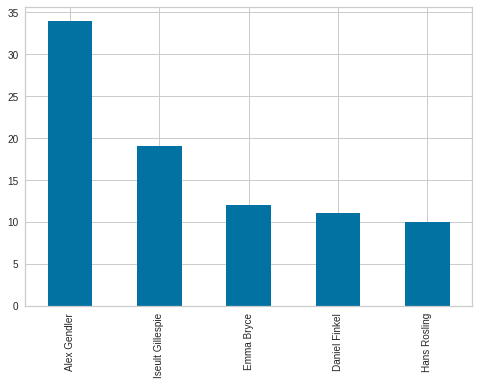

In [ ]:
df['speaker_1'].value_counts().head(5).plot(kind='bar');

In [ ]:
df['comments'].fillna(0,axis=0,inplace=True)

## We will later on fill these 0 values with mean once we remove outliers

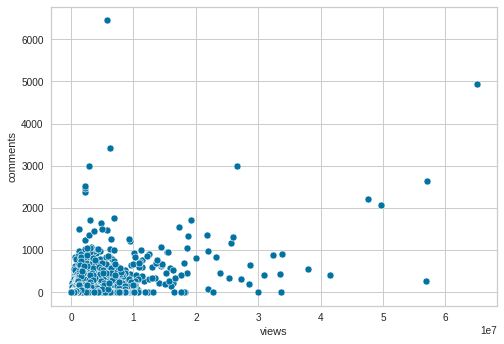

In [ ]:
sns.scatterplot(x='views',y='comments',data=df);

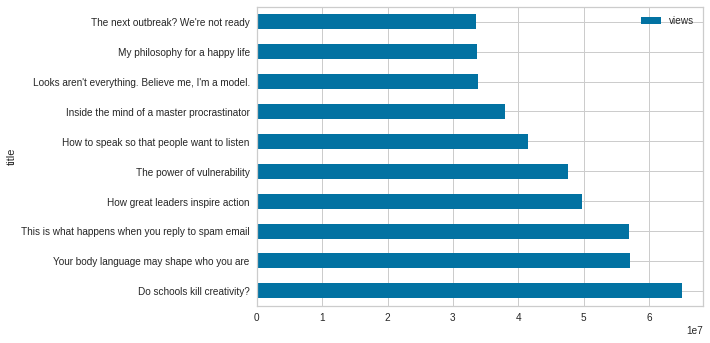

In [ ]:
df[['title','views']].sort_values('views',ascending=False).set_index('title').head(10).plot(kind='barh');

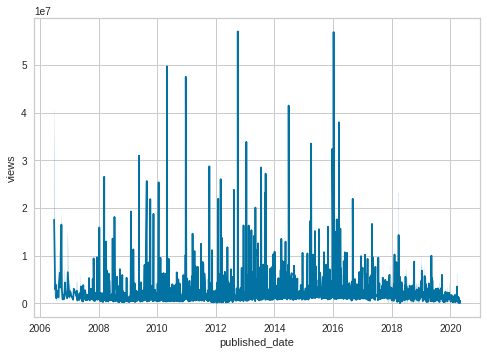

In [ ]:
sns.lineplot(x='published_date',y='views',data=df)

In [ ]:
lemmat = WordNetLemmatizer()
stop = stopwords.words('english')
num_to_word = inflect.engine()

In [ ]:
def token_normalize(text):
  lower_case_text = " ".join([word.lower() for word in text.split(" ")])
  no_punc_text = " ".join([re.sub(r'[^\w\s]', '', word) for word in lower_case_text.split(" ") if word != ''])
  no_stop_text = " ".join([word for word in no_punc_text.split(" ") if word not in stop])
  #num_to_word_text = " ".join([num_to_word.number_to_words(word) if word.isdigit() else word for word in no_stop_text.split(" ")])
  final_text =" ".join([lemmat.lemmatize(word) for word in no_stop_text.split(" ") if len(word) > 2])
  return final_text

In [ ]:
df['token_transcript'] = df['transcript'].apply(token_normalize)

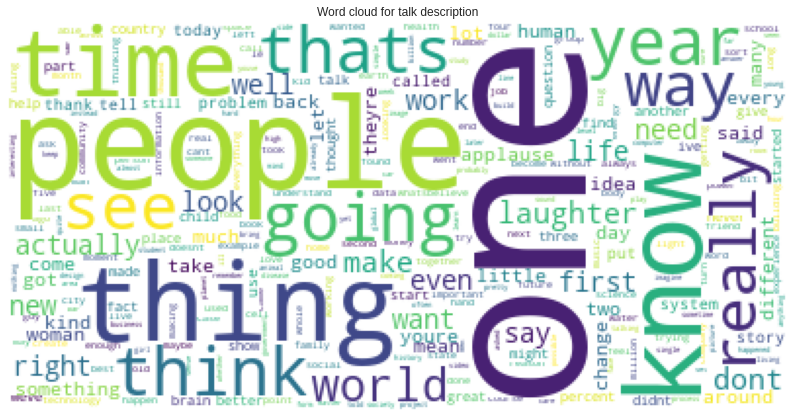

In [ ]:
plt.figure(figsize = (14,8))
wc = WordCloud(max_words = 500 ,background_color = 'white',collocations=False).generate(" ".join(df['token_transcript']))
plt.grid("off")
plt.axis("off")
plt.title("Word cloud for talk description")
plt.imshow(wc);

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=2000)
T = vectorizer.fit_transform(df['token_transcript'])

In [ ]:
X = T.toarray() 
X.shape

(4005, 2000)

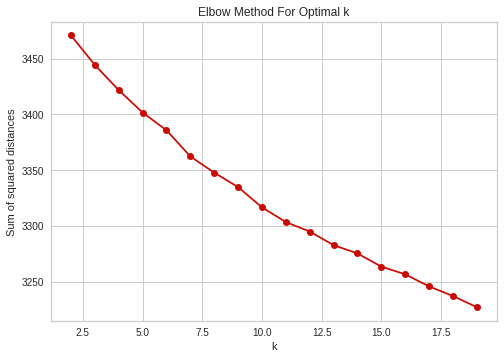

In [ ]:
ss = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k,n_init=5, max_iter=200)
    km = km.fit(X)
    ss.append(km.inertia_)
plt.plot(K, ss,'ro-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
def silhouette_score_analysis(n):

  for n_clusters in range(2,n):
      km = KMeans (n_clusters=n_clusters)
      preds = km.fit_predict(X)
      centers = km.cluster_centers_

      score = silhouette_score(X, preds, metric='euclidean')
      print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

      visualizer = SilhouetteVisualizer(km)

      visualizer.fit(X) # Fit the training data to the visualizer
      visualizer.poof() # Draw/show/poof the data

For n_clusters = 2, silhouette score is 0.015921647589211458


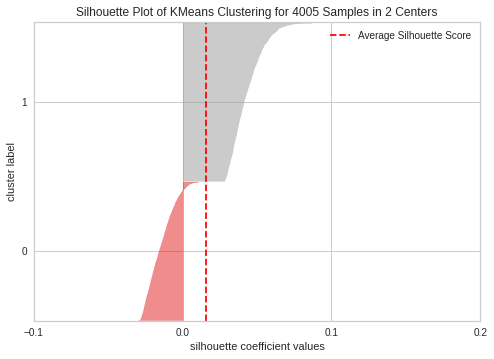

For n_clusters = 3, silhouette score is 0.003703076171875201


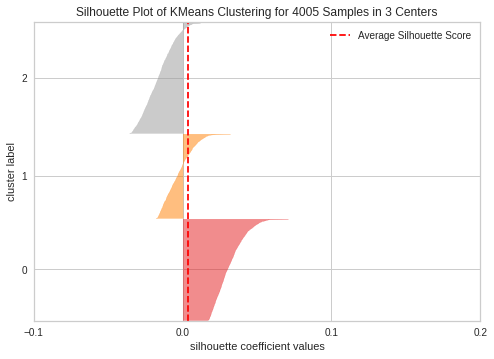

For n_clusters = 4, silhouette score is 0.007592340317944998


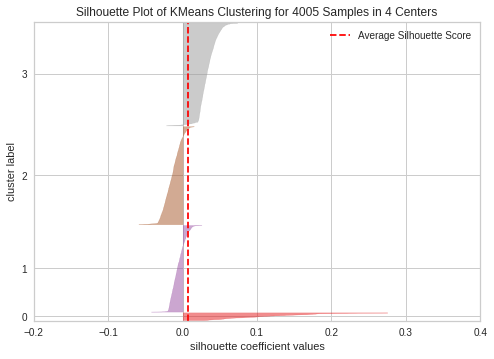

For n_clusters = 5, silhouette score is 0.008283521380246276


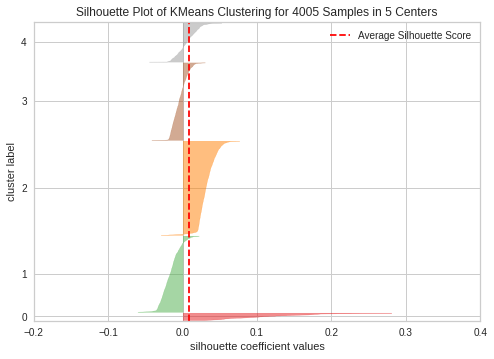

For n_clusters = 6, silhouette score is 0.008314632110800566


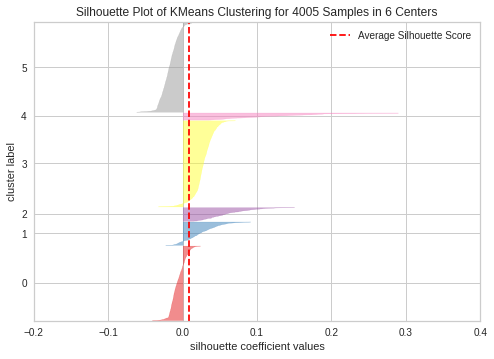

For n_clusters = 7, silhouette score is 0.008930378637512252


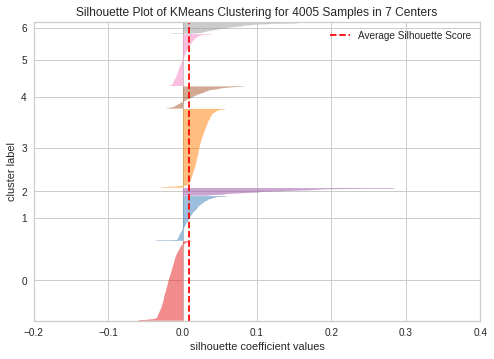

For n_clusters = 8, silhouette score is 0.008139561486850399


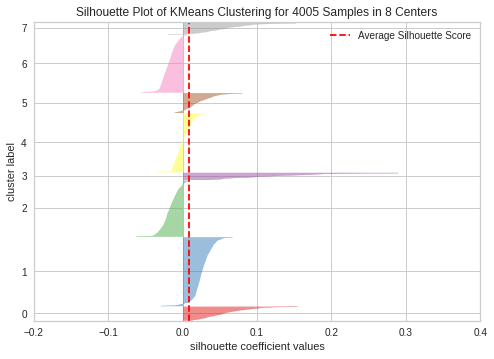

For n_clusters = 9, silhouette score is 0.00996817978792023


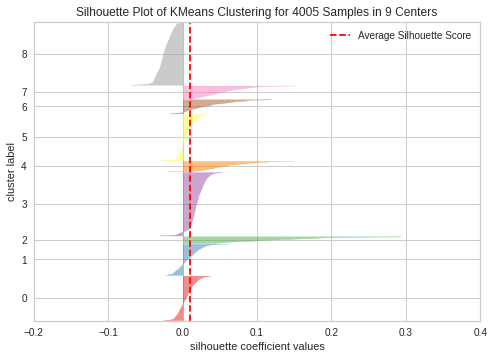

For n_clusters = 10, silhouette score is 0.011540316361118259


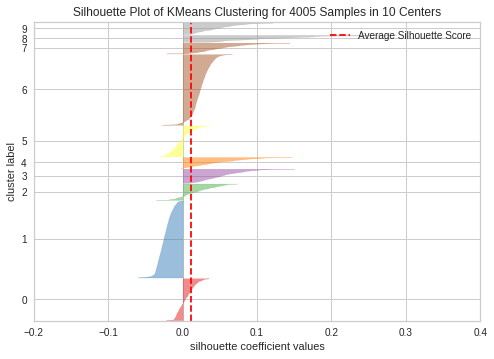

In [ ]:
silhouette_score_analysis(11)

### Going with 8 clusters

In [ ]:
nmf = NMF(n_components=8,random_state=0)
topics = nmf.fit_transform(X)

In [ ]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 15 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i]for i in topic.argsort()[-10:]])
    print('\n')

Top 15 words for topic #0:
['get', 'one', 'think', 'people', 'really', 'know', 'going', 'like', 'thing', 'laughter']


Top 15 words for topic #1:
['specie', 'sea', 'animal', 'light', 'energy', 'universe', 'ocean', 'planet', 'earth', 'water']


Top 15 words for topic #2:
['dollar', 'africa', 'year', 'need', 'percent', 'company', 'government', 'world', 'country', 'people']


Top 15 words for topic #3:
['tissue', 'health', 'dna', 'blood', 'body', 'drug', 'disease', 'patient', 'cancer', 'cell']


Top 15 words for topic #4:
['mother', 'said', 'school', 'story', 'life', 'family', 'men', 'girl', 'child', 'woman']


Top 15 words for topic #5:
['hear', 'piece', 'note', 'instrument', 'singing', 'play', 'song', 'sound', 'applause', 'music']


Top 15 words for topic #6:
['language', 'behavior', 'sleep', 'signal', 'information', 'human', 'body', 'memory', 'neuron', 'brain']


Top 15 words for topic #7:
['people', 'art', 'community', 'project', 'architecture', 'new', 'space', 'design', 'building', '

In [ ]:
topic_values = nmf.transform(X)
df['Topic_Cluster'] = topic_values.argmax(axis=1)

In [ ]:
cat_dict = {0 : "Culture",
            1 : "Science and technology",
            2 : "International affairs",
            3 : "Health and medicine",
            4 : "Social issues",
            5 : "Music",
            6 : "Mental health",
            7 : "Innovation and design"

            }

In [ ]:
df['talk_category'] = df['Topic_Cluster'].map(cat_dict)

In [ ]:
df.head()

,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,description,transcript,date_diff,token_transcript,Topic_Cluster,talk_category
0,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"[ar, bg, cs, de, el, en, es, fa, fr, fr-ca, gl...",272.0,977,"[alternative energy, cars, climate change, cul...","{243: 'New thinking on the climate crisis', 54...",With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",122 days,thank much chris truly great honor opportunity...,0,Culture
1,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"[ar, az, bg, bn, bs, cs, da, de, el, en, es, e...",628.0,1190,"[Africa, Asia, Google, demo, economics, global...","{2056: 'Own your body's data', 2296: 'A visual...",You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",125 days,year ago took task teach global development sw...,2,International affairs
2,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"[ar, bg, de, el, en, es, fa, fr, he, hr, hu, i...",124.0,1286,"[computers, entertainment, interface design, m...","{1725: '10 top time-saving tech tips', 2274: '...",New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",123 days,music sound silence simon garfunkel hello voic...,0,Culture
3,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"[ar, bg, bn, ca, cs, de, en, es, fa, fi, fr, h...",219.0,1116,"[MacArthur grant, activism, business, cities, ...",{1041: '3 stories of local eco-entrepreneurshi...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,121 days,youre today happy youve heard sustainable deve...,7,Innovation and design
4,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"[af, ar, az, be, bg, bn, ca, cs, da, de, el, e...",4931.0,1164,"[children, creativity, culture, dance, educati...","{865: 'Bring on the learning revolution!', 173...",Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,122 days,good morning audience good great hasnt ive blo...,0,Culture


In [ ]:
df.drop(['topics','description','transcript','date_diff','token_transcript','Topic_Cluster'],axis=1,inplace=True)

In [ ]:
df['talk_category'].unique()

array(['Culture', 'International affairs', 'Innovation and design',
       'Social issues', 'Music', 'Mental health',
       'Science and technology', 'Health and medicine'], dtype=object)

In [ ]:
topic_df = pd.DataFrame(df.groupby(['talk_category'])['views'].mean()).reset_index().sort_values('views',ascending=False)
topic_df 

,talk_category,views
0,Culture,3.108544e+06
4,Mental health,2.737170e+06
7,Social issues,2.021712e+06
5,Music,1.929802e+06
3,International affairs,1.769917e+06
6,Science and technology,1.675092e+06
1,Health and medicine,1.645534e+06
2,Innovation and design,1.426392e+06


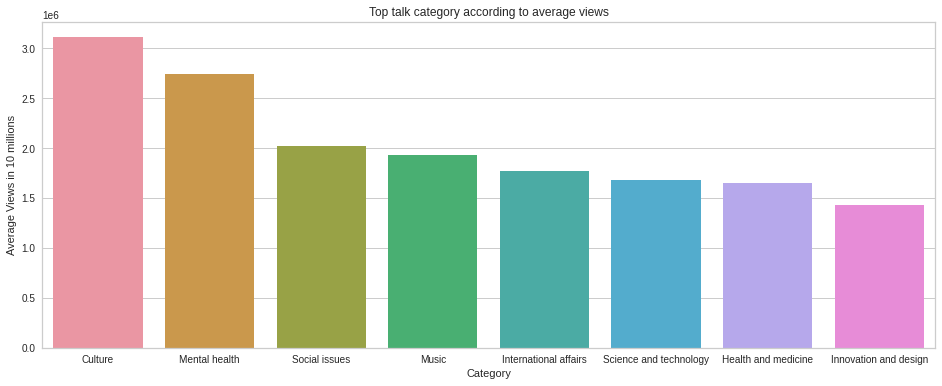

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Top talk category according to average views')
sns.barplot(x='talk_category',y='views',data=topic_df)
plt.xlabel("Category")
plt.ylabel('Average Views in 10 millions');

In [ ]:
df['weekday'] = df['published_date'].apply(lambda x : x.day_name())

In [ ]:
df['year'] = df['published_date'].apply(lambda x : x.year)

In [ ]:
week_df = pd.DataFrame(df.groupby(['weekday'])['views'].count()).reset_index().sort_values('views',ascending=False)
week_df

,weekday,views
5,Tuesday,857
4,Thursday,832
0,Friday,789
1,Monday,727
6,Wednesday,703
3,Sunday,55
2,Saturday,42


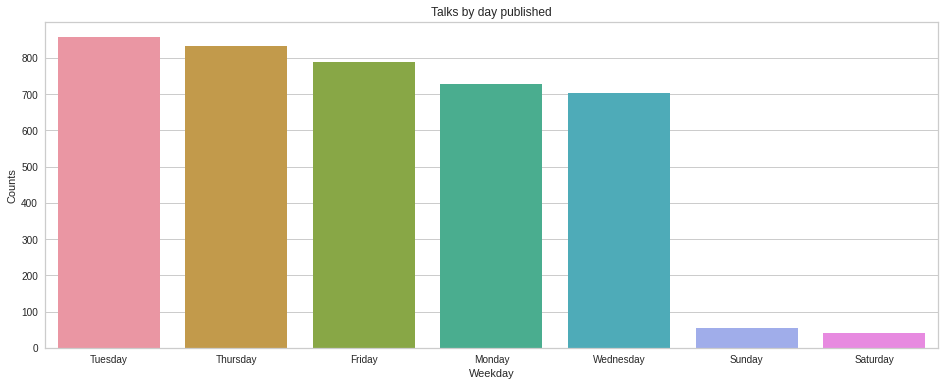

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Talks by day published')
sns.barplot(x='weekday',y='views',data=week_df)
plt.xlabel("Weekday")
plt.ylabel('Counts');

In [ ]:
df.head()

,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,related_talks,talk_category,weekday,year
0,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,en,"[ar, bg, cs, de, el, en, es, fa, fr, fr-ca, gl...",272.0,977,"{243: 'New thinking on the climate crisis', 54...",Culture,Tuesday,2006
1,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"[ar, az, bg, bn, bs, cs, da, de, el, en, es, e...",628.0,1190,"{2056: 'Own your body's data', 2296: 'A visual...",International affairs,Tuesday,2006
2,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"[ar, bg, de, el, en, es, fa, fr, he, hr, hu, i...",124.0,1286,"{1725: '10 top time-saving tech tips', 2274: '...",Culture,Tuesday,2006
3,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"[ar, bg, bn, ca, cs, de, en, es, fa, fi, fr, h...",219.0,1116,{1041: '3 stories of local eco-entrepreneurshi...,Innovation and design,Tuesday,2006
4,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"[af, ar, az, be, bg, bn, ca, cs, da, de, el, e...",4931.0,1164,"{865: 'Bring on the learning revolution!', 173...",Culture,Tuesday,2006
